In [86]:
import pandas as pd
import os
from rdflib import Graph, Namespace
from collections import defaultdict
from tqdm.notebook import tqdm
import json

study_ttl_path = './ttl/study.ttl' # contains the actual study data
omics_model_ttl_path = './ttl/omics_model.ttl' # contains the ontology
violation_report_ttl_path = './ttl/violation_report.ttl' # contains the shacl violation test case result


In [87]:
def tabularize_graphs(study: Graph, violations: Graph):
    SH = Namespace("http://www.w3.org/ns/shacl#")
    csv_file = "./csv/study.csv"
    violation_list_file = "./json/violation_list.json"

    if os.path.isfile(csv_file) and os.path.isfile(violation_list_file):
        print(csv_file ,"already exists")
        return

    # Create a dictionary to hold violation counts for each focusNode-sourceShape pair
    violation_counts = defaultdict(lambda: defaultdict(int))
    current_focus_node = None
    violation_list = []

    for s, p, o in tqdm(sorted(violations, key=lambda x: str(x[0])), desc="Processing violations"):  # sorting triples based on subject
        if p == SH.focusNode:
            current_focus_node = str(o)
        elif current_focus_node and p == SH.sourceShape:
            violation_list += [str(o)]
            violation_counts[current_focus_node][str(o)] += 1

    violation_list = list(set(violation_list))
    
    # Save violation_list to a JSON file
    with open(violation_list_file, 'w') as f:
        json.dump(violation_list, f)  

    # Initialize study DataFrame with indices as focusNodes and columns as sourceShapes
    study_df = pd.DataFrame(violation_counts).T.fillna(0)

    for s, p, o in tqdm(study, desc="Processing study"):
        if str(s) in study_df.index:
            if str(p) not in study_df.columns:
                study_df[str(p)] = ""
            study_df.at[str(s), str(p)] = str(o)

    study_df.to_csv(csv_file)

In [98]:
study_df = pd.read_csv('./csv/study.csv', index_col=0)
study_df.head()

,http://data.boehringer.com/ontology/omics/ece15faa-30b3-471c-ae51-2d6d1f80e3a9,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasStrandedness,http://data.boehringer.com/ontology/omics/38c0a1c7-1c92-489a-a22e-87f5335ccb1a,http://data.boehringer.com/ontology/omics/9589ebf0-6f4f-4b80-9a5a-75aa25b5715f,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isPreparedByLibrary,http://data.boehringer.com/ontology/omics/248e9792-8549-4e0d-8665-06c42aff8ffc,http://data.boehringer.com/ontology/omics/0c2600b5-30b2-40c7-917a-b402e73f55ae,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-hasSequencingProtocol,http://data.boehringer.com/ontology/omics/TranscriptOmicsSampleShape-isMeasuredOnPlatform,http://data.boehringer.com/ontology/omics/afb51f95-5b17-45a4-b62d-c58f4998f930,...,http://data.boehringer.com/ontology/omics/isPartOfProject,http://data.boehringer.com/ontology/omics/studyTitle,http://data.boehringer.com/ontology/omics/hasContactCompBio,http://data.boehringer.com/ontology/omics/sourceStudyId,http://data.boehringer.com/ontology/omics/hasStudyType,http://data.boehringer.com/ontology/omics/hasResponsibleSite,http://data.boehringer.com/ontology/omics/studyId,http://data.boehringer.com/ontology/omics/isSequencedForIndication,x,y
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_1652,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.643042,22.891825
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_959,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.036108,26.285522
http://data.boehringer.com/uuid/PrimaryCellSpecimen/b88ad57b-08d3-4b45-99f5-1864c80d1f10,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.317765,22.389988
http://data.boehringer.com/uuid/TranscriptOmicsSample/sample-EX51-EX51_1253,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.987753,14.131954
http://data.boehringer.com/uuid/PrimaryCellSpecimen/802f9bb2-1f46-457b-aef5-3273caaa9c57,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.207690,26.049303


In [88]:
print("Reading study graph...")
study_graph = Graph()
study_graph.parse(study_ttl_path, format="ttl")

print("Reading violations graph...")
violations_graph = Graph()
violations_graph.parse(violation_report_ttl_path, format="ttl")

tabularize_graphs(study_graph, violations_graph)


Reading study graph...
Reading violations graph...


Processing violations:   0%|          | 0/286592 [00:00<?, ?it/s]

Processing study:   0%|          | 0/97772 [00:00<?, ?it/s]

In [89]:
# print violation_list
violation_list_file = "./json/violation_list.json"
with open(violation_list_file, 'r') as f:
    violation_list = json.load(f)
print(len(violation_list), "violations found")

18 violations found


In [90]:
# load csv file


Creating UMAP embedding... (this may take some time)
UMAP(n_neighbors=68.97825744392213, random_state=0, verbose=True)
Mon Jun 19 15:57:36 2023 Construct fuzzy simplicial set
Mon Jun 19 15:57:36 2023 Finding Nearest Neighbors
Mon Jun 19 15:57:36 2023 Building RP forest with 8 trees
Mon Jun 19 15:57:36 2023 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
Mon Jun 19 15:57:37 2023 Finished Nearest Neighbor Search
Mon Jun 19 15:57:38 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 19 15:58:10 2023 Finished embedding
UMAP embedding created and saved to ./csv/study.csv


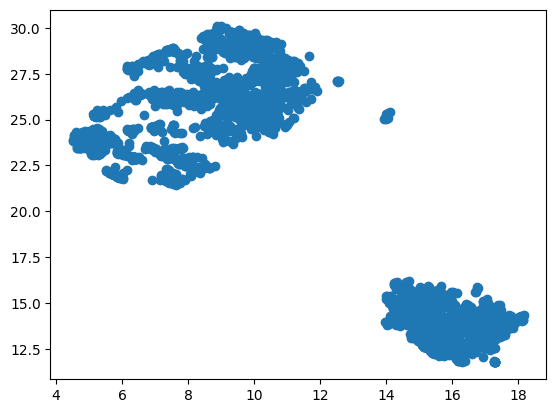

In [96]:
from matplotlib import pyplot as plt
import umap
import pandas as pd
import json
import numpy as np

def create_embedding():
    csv_file = "./csv/study.csv"
    violation_list_file = "./json/violation_list.json"

    # read study.csv
    study_df = pd.read_csv(csv_file, index_col=0)
    
    # read violation_list.json
    with open(violation_list_file, 'r') as f:
        violation_columns = json.load(f)
    
    view_df = study_df[violation_columns] # view of study dataframe with only violation columns

    print("Creating UMAP embedding... (this may take some time)")
    reducer = umap.UMAP(n_neighbors=np.sqrt(len(view_df)), min_dist=0.1, n_components=2, random_state=0, verbose=True)
    embedding = reducer.fit_transform(view_df) # 2D projection

    study_df["x"] = embedding[:, 0]
    study_df["y"] = embedding[:, 1]

    study_df.to_csv(csv_file)
    print("UMAP embedding created and saved to", csv_file)
    

def plot_embedding():
    csv_file = "./csv/study.csv"
    
    # read study.csv
    study_df = pd.read_csv(csv_file, index_col=0)

    plt.scatter(study_df["x"], study_df["y"])
    plt.show()

create_embedding()
plot_embedding()


In [ ]:
# TODO process ontology to differentiate between nan values: relation cannot exist given ontology, or relation is actually missing. also potentially that there is a relation when there shouldn't be but that would me more difficult to handle in the data afterwards